# Implementación del Quantum Approximate Optimization Algorithm (QAOA) para el modelo de Ising y el problema del corte máximo

## Modelo de Ising 

Queremos obtener el mínimo del hamiltoniano correspondiente a un modelo de Ising

$$H = \sum_{i,j=1}^n J_{i,j}Z_iZ_j + \sum_{i=1}^n h_iZ_i$$

Para ello, emplearemos el algoritmo QAOA.

Comenzamos definiendo una función que prepara un estado dependiendo de parámetros (ángulos) $\beta,\gamma$ y otra que estima su energía con respecto a $H$. 

In [1]:
import projectq
from projectq.ops import All, Measure, QubitOperator, H, R, CNOT

import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

def state(eng,n,p,J,h,angles):
# eng es el engine (simulador, hardware real...) sobre el que se trabaja
# n es el número de spines (qubits)
# p es el parámetro del QAOA
# J es un diccionario con las conexiones (i,j) del modelo y sus pesos
# h es un diccionario con los qubits que tienen un peso no nulo y sus pesos correspondientes
# angles la secuencia de ángulos; alternan los de la parte Z y los de la parte X  
       
    # Crear un registro de n qubits
    q = eng.allocate_qureg(n)
    # Superposición inicial. Estado |s>
    for a in range(n):
        H | q[a]
    # Creamos la parte del cirucito correspondiente a cada ángulo
    for a in range(p):
        # Conexiones JijZij
        for (i,j) in J:
            CNOT | (q[i],q[j])
            R(angles[a]*J[(i,j)]) | q[j]
            CNOT | (q[i],q[j])
        # Parte hiZi
        for i in h:
            R(angles[a]*h[i]) | q[i]
        # Añadimos las rotaciones correspondientes a la parte X
        for i in range(n):
            H | q[i]
            R(angles[a+1]) | q[i]
            H | q[i]
    #Volcamos todo
    eng.flush()
    return q

def expectation_circuit(n, p, J, h, angles, reps = 200):
# n es el número de spines (qubits)
# p es el parámetro del QAOA
# J es un diccionario con las conexiones (i,j) del modelo y sus pesos
# h es un diccionario con los qubits que tienen un peso no nulo y sus pesos correspondientes
# angles la secuencia de ángulos; alternan los de la parte Z y los de la parte X
# reps es el número de repeticiones para la estimación
    energy = 0.0
    
    for i in range(reps):
        # Inicializar el simulador
        eng = projectq.MainEngine()
        # Preparar el estado
        q = state(eng,n,p,J,h,angles)                
        #Medimos
        All(Measure) | q
        # flush
        eng.flush()
        #Medimos la energía en cada conexión
        for (i,j) in J:
            qi = int(q[i])
            qj = int(q[j])
            if qi==qj:
                energy = energy + J[(i,j)]
            else:
                energy = energy - J[(i,j)]
        #Y en cada elemento de la suma de los hiZi
        for i in h:
            qi = int(q[i])
            if qi==0:
                energy = energy + h[i]
            else:
                energy = energy - h[i]
    return energy/reps


Vamos a ver cómo el número de repeticiones influye en la estimación de la energía. Para ello, definimos un modelo de Ising que se corresponde con el problema de buscar el corte máximo en el grafo de la figura

<img src="max-cut.png" width="60%">

In [2]:
n = 5
J = {(0,1):1,(0,2):1,(1,2):1,(1,3):1,(2,4):1,(3,4):1}
h = {}

Ahora, fijamos $p=1$ y tomamos los ángulos $\beta$ y $\gamma$ iguales, para dibujar una gráfica bidimensional. Comenzamos con solamente 10 repeticiones.

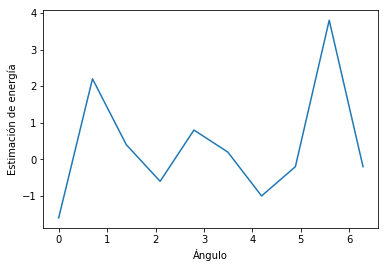

In [3]:
params_range = np.linspace(0.0, 2 * np.pi, 10)
data = [expectation_circuit(n,1,J,h,[params,params],10) for params in params_range]
 
plt.xlabel('Ángulo')
plt.ylabel('Estimación de energía')
plt.plot(params_range, data)
plt.show()



Estimamos de nuevo, pero ahora con 100 repeticiones

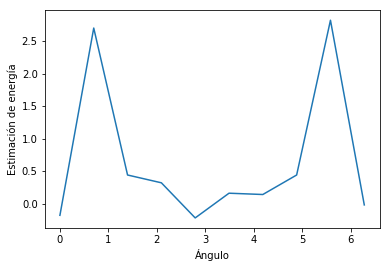

In [4]:
data = [expectation_circuit(n,1,J,h,[params,params],100) for params in params_range]
 
plt.xlabel('Ángulo')
plt.ylabel('Estimación de energía')
plt.plot(params_range, data)
plt.show()



Y, ahora, con 500

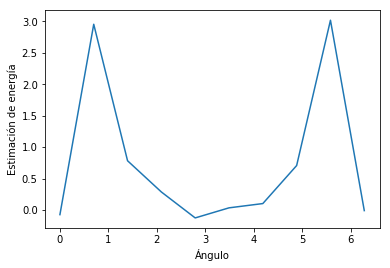

In [5]:
data = [expectation_circuit(n,1,J,h,[params,params],500) for params in params_range]
 
plt.xlabel('Ángulo')
plt.ylabel('Estimación de energía')
plt.plot(params_range, data)
plt.show()



Puesto que estamos utilizando un simulador, podemos calcular la energía del estado de forma exacta (que, además, es más rápido). Para ello, definimos una nueva función.

In [6]:
def exact_circuit(n,p,J,h, angles):
# n es el número de spines (qubits)
# p es el parámetro del QAOA
# J es un diccionario con las conexiones (i,j) del modelo y sus pesos
# h es un diccionario con los qubits que tienen un peso no nulo y sus pesos correspondientes
# angles la secuencia de ángulos; alternan los de la parte Z y los de la parte X
# reps es el número de repeticiones para la estimación

        # Inicializar el simulador
        eng = projectq.MainEngine()
        # Preparar el estado
        q = state(eng,n,p,J,h,angles) 
        
        #Definimos el hamiltoniano
        terminos=[]
        #Parte JijZiZj
        hamiltonian = 0*QubitOperator("Z0")
        for (i,j) in J:
            hamiltonian = hamiltonian + J[(i,j)]*QubitOperator("Z"+str(i)+" Z"+str(j))
        #Parte hiZi
        for i in h:
            hamiltonian = hamiltonian + h[i]*QubitOperator("Z"+str(i))
            
        
        #Calculamos la energía
        energy = eng.backend.get_expectation_value(hamiltonian, q)   
        # Medimos (si no, da error)
        All(Measure) | q
        return energy


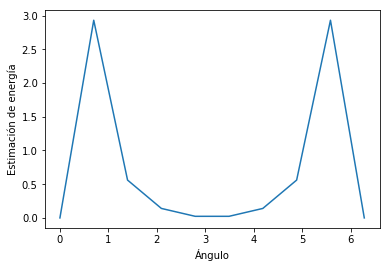

In [7]:
data = [exact_circuit(n,1,J,h,[params,params]) for params in params_range]
 
plt.xlabel('Ángulo')
plt.ylabel('Estimación de energía')
plt.plot(params_range, data)
plt.show()



A partir de este punto, entonces, usaremos el método exacto de estimación de la energía (aunque el ordenador cuántico **no tiene acceso a la función de onda** y, por tanto, debe usar la estimación midiendo y repitiendo)

Ahora empleamos el método QAOA para aproximar el valor mínimo del modelo de Ising que estamos empleando. Comenzamos con $p=1$ y con ángulos $\beta$ y $\gamma$ elegidos al azar. 

Definimos una función que sólo depende de los ángulos y que luego minimizamos con un algoritmo clásico.

In [8]:
p=1
def energy(params):
    return exact_circuit(n,p,J,h, params)
    
initial_params = [np.random.uniform(0, np.pi*2, 2)]
minimum=minimize(energy, initial_params, method='L-BFGS-B') 
print("Valor mínimo", minimum.fun)
print("Alcanzado en", minimum.x)

Valor mínimo -0.9974643653801095
Alcanzado en [2.04635753 4.12643022]


Como estamos usando el método exacto para estimar la energía, no medimos la función de onda en ningún momento. En la aplicación real del método, con el ordenador cuántico, para cada estimación realizaríamos una serie de mediciones para estimar la energía y podríamos guardar el valor mínimo obtenido como mejor solución. 

Para simular este comportamiento, vamos a realizar una serie de mediciones sobre el estado que hemos obtenido al minimizar y vamos a quedarnos con la mejor solución de esas mediciones. Para ello, modificamos ligeramente la función de estimación de energía, para que nos devuelva la mejor solución con su valor de energía.

In [9]:
def min_energy(n, p, J, h, angles, reps = 200):
# n es el número de spines (qubits)
# p es el parámetro del QAOA
# J es un diccionario con las conexiones (i,j) del modelo y sus pesos
# h es un diccionario con los qubits que tienen un peso no nulo y sus pesos correspondientes
# angles la secuencia de ángulos; alternan los de la parte Z y los de la parte X
# reps es el número de repeticiones para la estimación

    # Esta es la energía máxima posible
    best_energy = sum(abs(J[i,j]) for (i,j) in J)+sum(abs(h[i]) for i in h)         
    best_q = [0 for _ in range(n)] # valor inicial, temporal, de la mejor solución encontrada
    
    for i in range(reps):
        # Inicializar el simulador
        eng = projectq.MainEngine()
        # Preparar el estado
        q = state(eng,n,p,J,h,angles) 
                
        #Medimos
        All(Measure) | q
        # flush
        eng.flush()
        #Medimos la energía en cada conexión
        energy = 0
        for (i,j) in J:
            qi = int(q[i])
            qj = int(q[j])
            if qi==qj:
                energy = energy + J[(i,j)]
            else:
                energy = energy - J[(i,j)]
        #Y en cada elemento de la suma de los hiZi
        for i in h:
            qi = int(q[i])
            if qi==0:
                energy = energy + h[i]
            else:
                energy = energy - h[i]            
                    
                    
        if(energy<=best_energy):
            best_energy=energy
            best_q=[int(q[i]) for i in range(n)]
            
            
    return best_energy,best_q


Utilizamos esta función para obtener una aproximación de la solución al problema

In [10]:
e,q = min_energy(n,p,J,h, minimum.x, 10)
print("Valor de la solución: ", e)
print("Alcanzada en: ",q)

Valor de la solución:  -4
Alcanzada en:  [0, 0, 1, 1, 0]


Ahora usamos $p$ mayor

In [11]:
p = 2

initial_params = [np.random.uniform(0, np.pi*2, 2*p)]
minimum=minimize(energy, initial_params, method='L-BFGS-B') 
print("Valor mínimo del QAOA", minimum.fun)
print("Alcanzado en", minimum.x)
e,q = min_energy(n,p,J,h, minimum.x, 10)
print("Valor de la solución: ", e)
print("Alcanzada en: ",q)

Valor mínimo del QAOA -2.3204111269561367
Alcanzado en [2.22947775 3.37498203 3.82338877 1.85411956]
Valor de la solución:  -4
Alcanzada en:  [0, 0, 1, 1, 0]
